In [ ]:
!pip install torch pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 46.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import arviz as az
import pymc as pm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from torch.distributions import constraints
import numpy as np

In [ ]:
data = load_breast_cancer()

In [ ]:
X, y = data.data, data.target

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_clean, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add Noise

In [ ]:
def add_noise_to_data(X, noise_factor=0.8, outlier_fraction = 0.1, outlier_scale=5):
    noise = noise_factor * torch.randn_like(X)
    X_noisy = X + noise
    X_noisy = torch.clamp(X_noisy, 0, 1)

    num_outliers = int(outlier_fraction * X.shape[0])  # Determine number of outlier points
    outlier_indices = torch.randint(0, X.shape[0], (num_outliers,))  # Randomly select outlier positions
    X_outliers = torch.randn_like(X[outlier_indices]) * outlier_scale  # Scale up for extreme values
    X_noisy[outlier_indices] = X_outliers
    return X_noisy

X_train = add_noise_to_data(X_clean, noise_factor = 1.5, outlier_fraction=0.25)

In [ ]:
pyro.clear_param_store()

# Model 1

In [ ]:
def model_MVN(X, y):
    w_prior = dist.MultivariateNormal(torch.zeros(X.shape[1]), torch.eye(X.shape[1]))  # Multivariate Normal for weights
    b_prior = dist.Normal(0., 1.)  # Normal prior for the bias

    # Sample weights and bias from the priors
    w = pyro.sample('w_MVN', w_prior)
    b = pyro.sample('b_MVN', b_prior)

    # Linear model: w * X + b
    logits = torch.matmul(X, w) + b
    probs = torch.sigmoid(logits)  # Sigmoid activation for binary classification

    # Likelihood: Bernoulli distribution for the binary target
    with pyro.plate('data', X.shape[0]):  # Plate to represent the batch dimension
        pyro.sample('obs', dist.Bernoulli(probs), obs=y)


def guide_MVN(X, y):
    # Define variational parameters for the weights and bias
    # Variational parameters for weights and bias
    w_loc = pyro.param('w_loc_MVN', torch.randn(X.shape[1]))  # Mean of variational distribution for weights
    w_scale = pyro.param('w_scale_MVN', torch.ones(X.shape[1]), constraint=torch.distributions.constraints.positive)  # Scale of variational distribution for weights
    b_loc = pyro.param('b_loc_MVN', torch.randn(1))  # Mean of variational distribution for bias
    b_scale = pyro.param('b_scale_MVN', torch.ones(1), constraint=torch.distributions.constraints.positive)  # Scale of variational distribution for bias

    # Variational distribution for the weights: Multivariate Normal
    # Using a diagonal covariance matrix for the variational distribution (for simplicity)
    w_cov = torch.diag(w_scale)  # Covariance matrix for the variational distribution
    pyro.sample('w_MVN', dist.MultivariateNormal(w_loc, w_cov))  # Multivariate Normal for weights

    # Variational distribution for the bias
    pyro.sample('b_MVN', dist.Normal(b_loc, b_scale))  # Normal for bias


# Optimizer setup
adam_params = {"lr": 0.01}
optimizer = pyro.optim.Adam(adam_params)

# SVI setup
svi_MVN = SVI(model_MVN, guide_MVN, optimizer, loss=Trace_ELBO())

# Train the model with Stochastic Variational Inference (SVI)
num_steps = 5000
for step in range(num_steps):
    loss = svi_MVN.step(X_train, y_train)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")


Step 0, Loss: 1578.7321645021439
Step 100, Loss: 859.287283539772
Step 200, Loss: 881.3425590693951
Step 300, Loss: 764.1855833530426
Step 400, Loss: 688.4362735748291
Step 500, Loss: 595.8538405299187
Step 600, Loss: 630.0405671000481
Step 700, Loss: 573.3986049294472
Step 800, Loss: 519.4560416936874
Step 900, Loss: 561.85893201828
Step 1000, Loss: 470.44886207580566
Step 1100, Loss: 461.67816972732544
Step 1200, Loss: 440.5407588481903
Step 1300, Loss: 406.1391427516937
Step 1400, Loss: 429.71373879909515
Step 1500, Loss: 421.84645652770996
Step 1600, Loss: 419.16649627685547
Step 1700, Loss: 399.78479021787643
Step 1800, Loss: 390.7075481414795
Step 1900, Loss: 399.0016187429428
Step 2000, Loss: 387.6051036119461
Step 2100, Loss: 394.0353356599808
Step 2200, Loss: 379.50456988811493
Step 2300, Loss: 372.2512494325638
Step 2400, Loss: 384.58768606185913
Step 2500, Loss: 374.44921696186066
Step 2600, Loss: 380.36322486400604
Step 2700, Loss: 376.56180119514465
Step 2800, Loss: 377.67

# Model 2

In [ ]:
def model_T(X, y):
    # Define priors with separate degrees of freedom
    df_w = pyro.sample("df_w", dist.Gamma(2.0, 1.0))
    df_b = pyro.sample("df_b", dist.Gamma(2.0, 1.0))

    w_prior = dist.StudentT(df=df_w, loc=torch.zeros(X.shape[1]), scale=torch.ones(X.shape[1]))
    b_prior = dist.StudentT(df=df_b, loc=torch.zeros(1), scale=torch.ones(1))

    # Sample weights and bias from the priors
    w = pyro.sample('w_T', w_prior.to_event(1))
    b = pyro.sample('b_T', b_prior)

    # Linear model: w * X + b
    logits = torch.matmul(X, w) + b
    probs = torch.sigmoid(logits)

    # Likelihood: Bernoulli distribution for the binary target
    with pyro.plate('data', X.shape[0]):
        pyro.sample('obs', dist.Bernoulli(probs), obs=y)


def guide_T(X, y):
    # Define separate variational parameters for degrees of freedom
    df_w_loc = pyro.param("df_w_loc", torch.tensor(2.0), constraint=dist.constraints.positive)
    df_b_loc = pyro.param("df_b_loc", torch.tensor(2.0), constraint=dist.constraints.positive)

    # Define variational parameters for weights and bias
    w_loc = pyro.param('w_loc_T', torch.randn(X.shape[1]))
    w_scale = pyro.param('w_scale_T', torch.ones(X.shape[1]), constraint=dist.constraints.positive)

    b_loc = pyro.param('b_loc_T', torch.randn(1))
    b_scale = pyro.param('b_scale_T', torch.ones(1), constraint=dist.constraints.positive)

    # Sample from variational distributions
    pyro.sample("df_w", dist.Gamma(df_w_loc, torch.tensor(1.0)))
    pyro.sample("df_b", dist.Gamma(df_b_loc, torch.tensor(1.0)))

    pyro.sample('w_T', dist.StudentT(df=df_w_loc, loc=w_loc, scale=w_scale).to_event(1))
    pyro.sample('b_T', dist.StudentT(df=df_b_loc, loc=b_loc, scale=b_scale))


# Optimizer setup
adam_params = {"lr": 0.01}
optimizer = pyro.optim.Adam(adam_params)

# SVI setup
svi_T = SVI(model_T, guide_T, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
for step in range(num_steps):
    loss = svi_T.step(X_train, y_train)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")

Step 0, Loss: 1451.0742225646973
Step 100, Loss: 1249.2944157719612
Step 200, Loss: 860.6573294997215
Step 300, Loss: 892.5200840234756
Step 400, Loss: 758.5884211957455
Step 500, Loss: 751.4257370233536
Step 600, Loss: 709.2040537595749
Step 700, Loss: 515.5235895812511
Step 800, Loss: 426.51879677176476
Step 900, Loss: 447.6380866765976
Step 1000, Loss: 466.38117691874504
Step 1100, Loss: 414.7974181175232
Step 1200, Loss: 420.3700292110443
Step 1300, Loss: 428.8336415886879
Step 1400, Loss: 402.79041466116905
Step 1500, Loss: 390.0174024105072
Step 1600, Loss: 390.4089918732643
Step 1700, Loss: 387.8736629486084
Step 1800, Loss: 372.3173620700836
Step 1900, Loss: 392.7220479249954
Step 2000, Loss: 377.32939088344574
Step 2100, Loss: 370.146448969841
Step 2200, Loss: 380.8597928285599
Step 2300, Loss: 382.9009493589401
Step 2400, Loss: 372.4022431373596
Step 2500, Loss: 377.67556285858154
Step 2600, Loss: 385.4571055173874
Step 2700, Loss: 376.7093379497528
Step 2800, Loss: 380.85494

In [ ]:
T_df_w_param = pyro.param("df_w_loc").detach().item()
T_df_b_param = pyro.param("df_b_loc").detach().item()

In [ ]:
T_scale_param_tensor = pyro.param('w_scale_T').detach()
T_mean_param_tensor = pyro.param('w_loc_T').detach()
T_bias_mean_param = pyro.param('b_loc_T').detach()
T_bias_scale_param = pyro.param('b_scale_T').detach()

In [ ]:
MVN_scale_param_tensor = pyro.param('w_scale_MVN').detach()
MVN_mean_param_tensor = pyro.param('w_loc_MVN').detach()
MVN_bias_mean_param = pyro.param('b_loc_MVN').detach()
MVN_bias_scale_param = pyro.param('b_scale_MVN').detach()

In [ ]:
r = np.diag(T_scale_param_tensor.numpy())

In [ ]:
vi_posterior_t = [dist.StudentT(pyro.param("df_w_loc").detach().item(), pyro.param('w_loc_T').detach()[i], pyro.param('w_scale_T').detach()[i])for i in range(30)]
vi_posterior = dist.MultivariateNormal(loc = pyro.param('w_loc_MVN').detach(), covariance_matrix= torch.diag(pyro.param('w_scale_MVN').detach()))
approx_posteriors = [vi_posterior, vi_posterior_t]

In [ ]:
print(approx_posteriors[1])

[StudentT(df: 5.653430938720703, loc: -0.09895879030227661, scale: 0.0456385612487793), StudentT(df: 5.653430938720703, loc: 0.044215358793735504, scale: 0.04504581168293953), StudentT(df: 5.653430938720703, loc: 0.010948525741696358, scale: 0.04367885738611221), StudentT(df: 5.653430938720703, loc: 0.015495412051677704, scale: 0.05105945095419884), StudentT(df: 5.653430938720703, loc: -0.1549273431301117, scale: 0.044504404067993164), StudentT(df: 5.653430938720703, loc: 0.001294627203606069, scale: 0.04250519350171089), StudentT(df: 5.653430938720703, loc: 0.0005807140842080116, scale: 0.042431484907865524), StudentT(df: 5.653430938720703, loc: 0.008955072611570358, scale: 0.047614581882953644), StudentT(df: 5.653430938720703, loc: 0.039317063987255096, scale: 0.04296054691076279), StudentT(df: 5.653430938720703, loc: 0.07291772961616516, scale: 0.04088817164301872), StudentT(df: 5.653430938720703, loc: -0.07197785377502441, scale: 0.0413556732237339), StudentT(df: 5.653430938720703,

# Pseudo BMA and Stacking for optimal weights

In [ ]:
rng = np.random.seed(2741)

In [ ]:
# Model 1: Multivariate Normal
with pm.Model() as model_mvnorm:
    # Priors (extracting from vi_posterior)
    intercept = pm.Normal('intercept', mu= MVN_bias_mean_param.numpy()[0], sigma= MVN_bias_scale_param.numpy()[0])
    coefs = pm.MvNormal('coefs', mu=vi_posterior.loc[0:].numpy(), cov=vi_posterior.covariance_matrix[:, :].numpy())


    # Logistic regression
    logits = pm.invlogit(intercept + pm.math.dot(X_train.numpy(), coefs))
    likelihood = pm.Bernoulli('likelihood', logit_p=logits, observed=y_train.numpy())

    idata_0 = pm.sample(draws=2000, tune=1000, target_accept=0.99, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_0, extend_inferencedata=True, random_seed=rng)

Output()

Output()

array([[<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

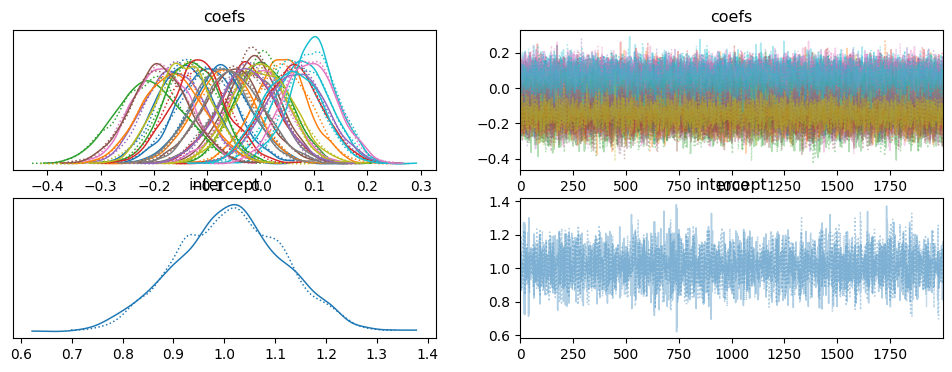

In [ ]:
pm.plot_trace(idata_0)

In [ ]:
# Model 2: Student T
with pm.Model() as model_studentt:
    # Priors (extracting from vi_posterior_t)
    intercept = pm.StudentT('intercept', mu= T_bias_mean_param.numpy()[0], sigma= T_bias_scale_param.numpy()[0], nu=T_df_b_param)
    coefs = pm.MvStudentT("coefs",mu=T_mean_param_tensor.numpy(),scale=r,nu=T_df_w_param)

    # Logistic regression
    logits = pm.invlogit(intercept + pm.math.dot(X_train.numpy(), coefs))
    likelihood = pm.Bernoulli('likelihood', logit_p=logits, observed=y_train.numpy())

    idata_1 = pm.sample(draws=2000, tune=1000, target_accept=0.99, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_1, extend_inferencedata=True, random_seed=rng)


Output()

Output()

array([[<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

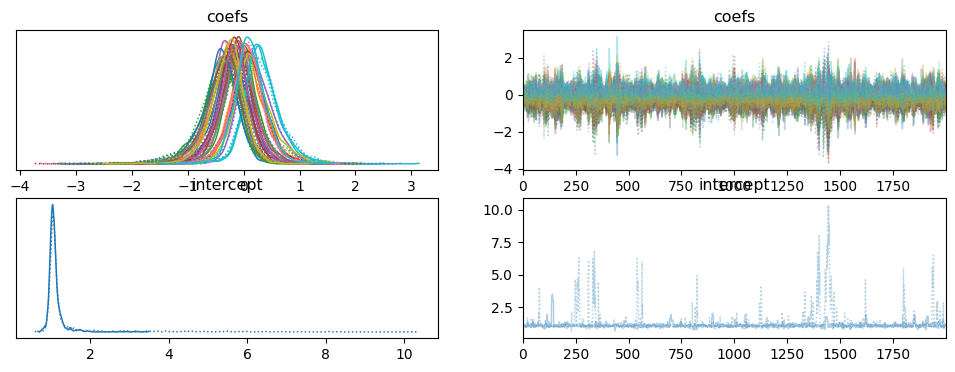

In [ ]:
pm.plot_trace(idata_1)

In [ ]:
model_dict = dict(zip(["model_mvnorm", "model_studentt"], [idata_0, idata_1]))
comp = az.compare(model_dict, method = "stacking")
comp

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_studentt,0,-283.036831,5.330861,0.000000,1.000000e+00,4.883917,0.000000,True,log
model_mvnorm,1,-289.839942,1.189707,6.803111,4.529710e-14,6.117121,1.825136,False,log


# Test Accuracy

In [ ]:
def predict_testset(X, num_samples=4000, w1=comp.loc['model_studentt', 'weight'], w2=comp.loc['model_mvnorm', 'weight']):
    # Student-T parameters (separate df for weights and bias)
    df_w = T_df_w_param
    df_b = T_df_b_param
    w_loc_T = pyro.param('w_loc_T')
    w_scale_T = pyro.param('w_scale_T')
    b_loc_T = pyro.param('b_loc_T')
    b_scale_T = pyro.param('b_scale_T')

    # MVN parameters
    w_loc_MVN = pyro.param('w_loc_MVN')
    w_cov_MVN = torch.diag(pyro.param('w_scale_MVN'))
    b_loc_MVN = pyro.param('b_loc_MVN')
    b_scale_MVN = pyro.param('b_scale_MVN')

    # Sample mixture components
    mix_component = torch.bernoulli(torch.full((num_samples,), w1))  # Choose component
    mix_component_copy = mix_component.clone()

    # Sample weights from mixture
    w_samples_T = dist.StudentT(df=df_w, loc=w_loc_T, scale=w_scale_T).sample((num_samples,))
    w_samples_MVN = dist.MultivariateNormal(w_loc_MVN, w_cov_MVN).sample((num_samples,))
    w_samples = torch.where(
        mix_component[:, None] == 1,
        w_samples_T,
        w_samples_MVN
    )

    # Sample biases from mixture
    b_samples_T = dist.StudentT(df=df_b, loc=b_loc_T, scale=b_scale_T).sample((num_samples,))
    b_samples_MVN = dist.Normal(b_loc_MVN, b_scale_MVN).sample((num_samples,))
    b_samples = torch.where(mix_component_copy[:, None] == 1, b_samples_T, b_samples_MVN)

    # Compute logits and average prediction
    logits = torch.matmul(X, w_samples.T) + b_samples.T
    probs = torch.sigmoid(logits).mean(dim=1)

    return (probs > 0.5).float()

In [ ]:
y_pred = predict_testset(X_test)
accuracy = (y_pred == y_test).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.4f}%")

Accuracy: 73.6842%


# SVI accuracy

In [ ]:
def predict(X, num_samples = 4000):
    # Get the learned parameters from the guide
    w_loc = pyro.param('w_loc_MVN')  # Mean of the weights
    w_cov = torch.diag(pyro.param('w_scale_MVN'))  # Covariance of the weights (diagonal for simplicity)
    b_loc = pyro.param('b_loc_MVN')  # Mean of the bias
    b_scale = pyro.param('b_scale_MVN')  # Std dev of the bias
    prob_samples = []
    for i in range(num_samples):
        # Sample from the variational distribution of w and b (posterior predictive sampling)
        w = dist.MultivariateNormal(w_loc, w_cov).sample()  # Sample weights
        b = dist.Normal(b_loc, b_scale).sample()  # Sample bias

        # Make predictions using the logistic model
        logits = torch.matmul(X, w) + b
        probs = torch.sigmoid(logits)
        prob_samples.append(probs)
    prob_samples = torch.stack(prob_samples)
    probs = prob_samples.mean(dim=0)
    return (probs > 0.5).float()  # Return binary predictions

# Predict on test data
y_pred_MVN = predict(X_test)

# Evaluate accuracy
accuracy = (y_pred_MVN == y_test).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.4f}%")

Accuracy: 76.3158%
